In [1]:
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Separação dos dados em treinamento e teste
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Pré-processamento dos dados. Imagens 28 x 28. Valores de pixels normalizados (0<=p<=1).
X_train = X_train.reshape((60000, 28 * 28))
X_train = X_train.astype('float32') / 255

X_test = X_test.reshape((10000, 28 * 28))
X_test = X_test.astype('float32') / 255

y_train = to_categorical(y_train)  # Convertendo rótulos para one-hot encoding
y_test = to_categorical(y_test)    # Convertendo rótulos para one-hot encoding

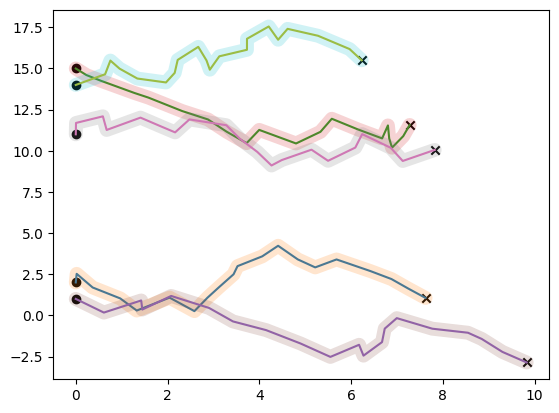

In [3]:
STEPS = 20
class Device:
    def __init__(self, name, model=None) -> None:
        self.model = model
        self.name = name
        self.xs = self.get_paths()[0]
        self.ys = self.get_paths()[1]

    def aggregate(self, neighbors: list, lmbda: int):
        theta_n = self.model.get_weights()
        parameters = [ [( lmbda / (len(neighbors) + 1) ) * (k-n) for k,n in zip(neighbor.model.get_weights(),theta_n)] for neighbor in neighbors]
        parameters_sum = [np.sum(z,axis=0) for z in zip(*parameters)]
        new_weights = [n + k for n,k in zip(self.model.get_weights(), parameters_sum)]
        self.model.set_weights(new_weights)

    def train_local(self,Xi, yi):
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        self.model.fit(Xi, yi, epochs=1, batch_size=32, verbose=0)

    def get_paths(self):
        xs,ys = [], []
        x,y = 0,random.randint(0,20)
        for i in range(STEPS):
            xs.append(x)
            ys.append(y)
            stepx = random.uniform(0,0.83)
            stepy = random.choice([-(0.83**2 - stepx**2)**0.5,(0.83**2 - stepx**2)**0.5])
            x = x + stepx
            y = y + stepy
        return xs,ys
    
    def get_neighbors(self,step: int,nodes: list, max_distance: float):
        neighbors = []
        for node in nodes:
            distance = ( (node.xs[step] - self.xs[step]) ** 2 + (node.ys[step] - self.ys[step]) ** 2 ) ** 0.5
            if ( (node.name != self.name) & (distance <= max_distance) ):
                neighbors.append(node)
        return neighbors

# m1 = Sequential()
# m1.add(Dense(units=3, activation='relu', input_dim=2))
# m1.add(Dense(units=4, activation='softmax'))

# m2 = Sequential()
# m2.add(Dense(units=3, activation='relu', input_dim=2))
# m2.add(Dense(units=4, activation='softmax'))

# m3 = Sequential()
# m3.add(Dense(units=3, activation='relu', input_dim=2))
# m3.add(Dense(units=4, activation='softmax'))

# d1 = Device(m1)
# d2 = Device(m2)
# d3 = Device(m3)

# print(d1.model.get_weights())
# print(d2.model.get_weights())
# print(d3.model.get_weights())

# d1.aggregate([d2,d3],1)
# print(d1.model.get_weights())

m = Sequential()
m.add(Dense(units=32, activation='relu', input_dim=784))
m.add(Dense(units=10, activation='softmax'))

n_devices = 5
devices = {f"d{k}":Device(name=f"d{k}",model=m) for k in range(n_devices)}



fig,axs = plt.subplots(1,1)

for k,d in devices.items():
    axs.plot(d.xs,d.ys)
    axs.plot(d.xs,d.ys, linewidth = 10,solid_capstyle='round', alpha = 0.2)
    axs.scatter(d.xs[0],d.ys[0], marker='o', color='black')
    axs.scatter(d.xs[-1],d.ys[-1], marker='x', color='black')


Step 0
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 1
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 2
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 3
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 4
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 5
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 6
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 7
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 8
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 9
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 10
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 11
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 12
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 13
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 14
Device d0..
Device d1..
Device d2..
Device d3..
De

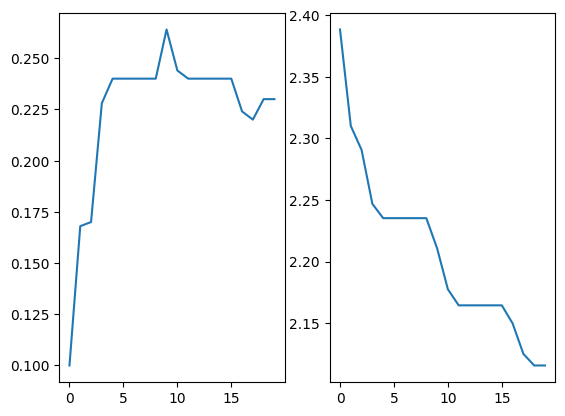

In [4]:
MAX_CHAOTIC_ENTRIES = 20
TRAIN_SIZE = 50
TEST_SIZE = 100

def return_loss_acc(max_distance):
    devs_loss_mean = []
    devs_accs_mean = []

    for s in range(STEPS):
        print(f"Step {s}")
        devices_loss = []
        devices_accs = []
        
        for i,(dname, device) in enumerate(devices.items()):
            print(f"Device {dname}..")
            # samples = random.sample(range(1, len(X_train)), random.randint(1, MAX_CHAOTIC_ENTRIES))
            # device.train_local(X_train[samples],y_train[samples])
            partition = TRAIN_SIZE // n_devices
            Xi = X_train[i * partition : (i+1) * partition ]
            yi = y_train[i * partition : (i+1) * partition ]

            neighbors = device.get_neighbors(step=s,nodes=devices.values(),max_distance=max_distance)

            if s == 0:
                device.train_local(Xi,yi)
            else:
                if len(neighbors) > 0:
                    device.aggregate(neighbors=neighbors,lmbda=1)
                    device.train_local(Xi,yi)
            
            loss, acc = device.model.evaluate(X_test[:TEST_SIZE], y_test[:TEST_SIZE], verbose=0)

            devices_loss.append(loss)
            devices_accs.append(acc)

        devs_loss_mean.append(np.mean(devices_loss))
        devs_accs_mean.append(np.mean(devices_accs))
    return devs_accs_mean, devs_loss_mean

fig, axs = plt.subplots(1,2)
res1 = return_loss_acc(max_distance=1)
axs[0].plot([s for s in range(STEPS)],res1[0])
axs[1].plot([s for s in range(STEPS)],res1[1])


Step 0
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 1
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 2
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 3
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 4
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 5
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 6
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 7
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 8
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 9
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 10
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 11
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 12
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 13
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 14
Device d0..
Device d1..
Device d2..
Device d3..
De

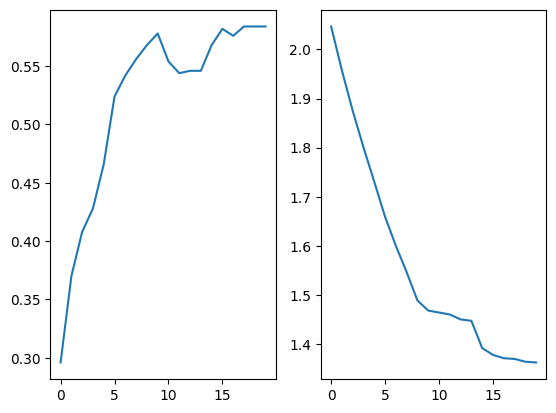

In [5]:
fig, axs = plt.subplots(1,2)
res2 = return_loss_acc(max_distance=4)
axs[0].plot([s for s in range(STEPS)],res2[0])
axs[1].plot([s for s in range(STEPS)],res2[1])

Step 0
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 1
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 2
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 3
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 4
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 5
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 6
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 7
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 8
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 9
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 10
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 11
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 12
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 13
Device d0..
Device d1..
Device d2..
Device d3..
Device d4..
Step 14
Device d0..
Device d1..
Device d2..
Device d3..
De

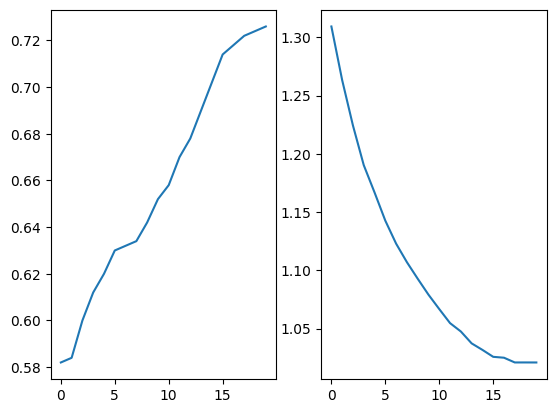

In [6]:
fig, axs = plt.subplots(1,2)
res3 = return_loss_acc(max_distance=8)
axs[0].plot([s for s in range(STEPS)],res3[0])
axs[1].plot([s for s in range(STEPS)],res3[1])